C:\Users\Tanishka Saini\AppData\Local\Temp\ipykernel_18028\921097131.py:96: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE)
[*********************100%***********************]  1 of 1 completed


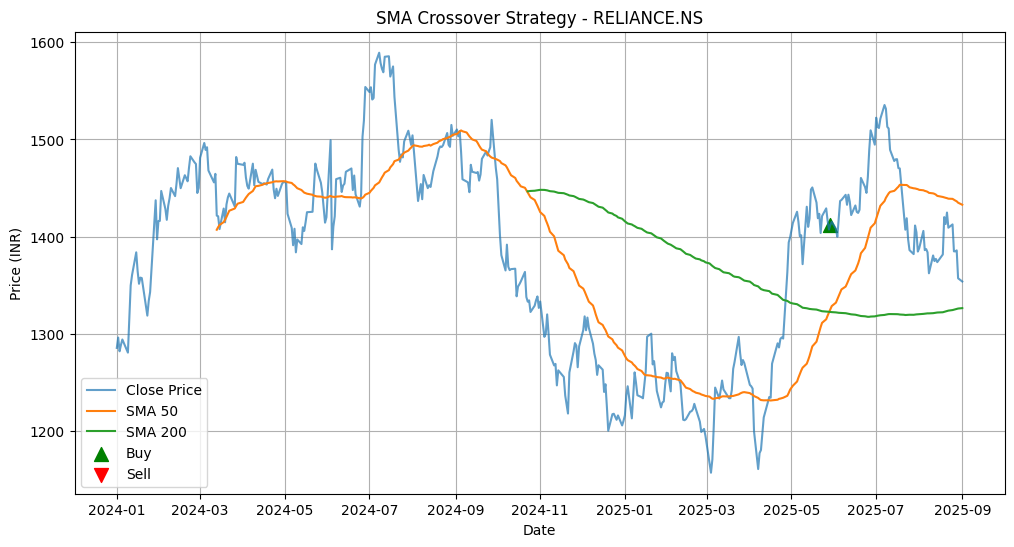

C:\Users\Tanishka Saini\AppData\Local\Temp\ipykernel_18028\921097131.py:96: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE)
[*********************100%***********************]  1 of 1 completed


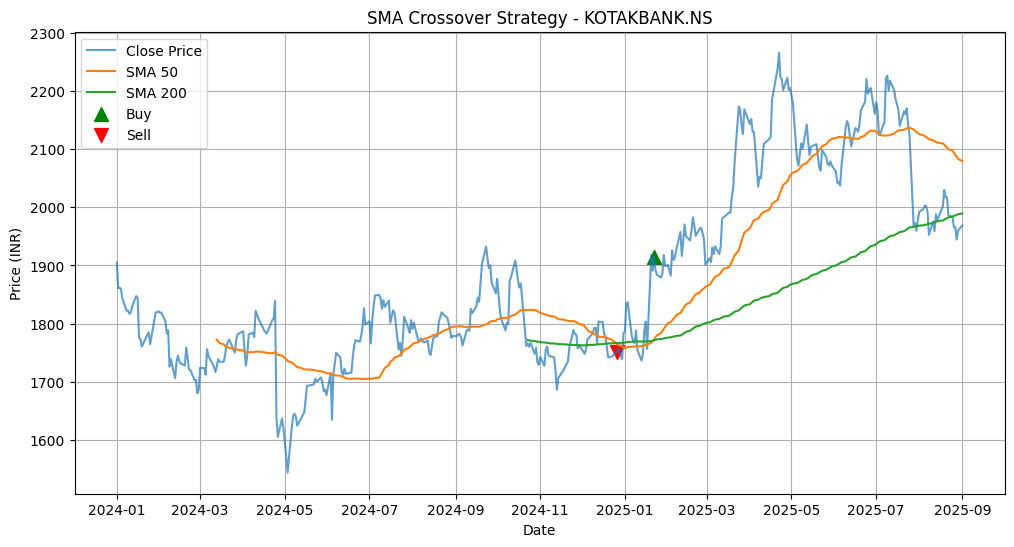

C:\Users\Tanishka Saini\AppData\Local\Temp\ipykernel_18028\921097131.py:96: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START_DATE)
[*********************100%***********************]  1 of 1 completed


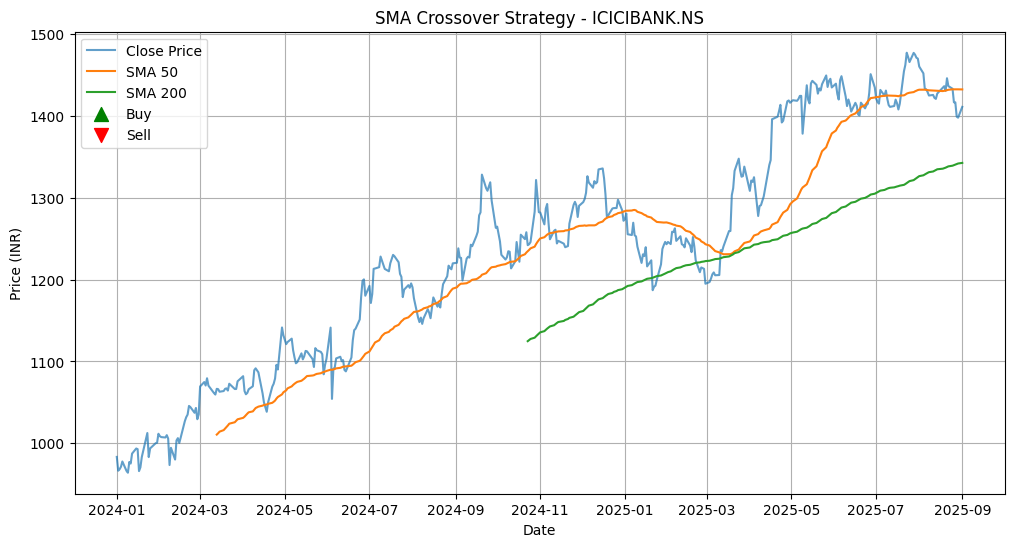

✅ SMA Crossover backtest complete. Trade logs & summary saved.


In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ===== Strategy Parameters =====
SMA_SHORT = 50
SMA_LONG = 200
START_DATE = "2024-01-01"
TICKERS = ["RELIANCE.NS", "KOTAKBANK.NS", "ICICIBANK.NS"]

# ===== Strategy Function =====
def sma_crossover_strategy(df):
    """Apply SMA crossover strategy on a given dataframe."""
    
    # Calculate SMAs
    df['SMA_Short'] = df['Close'].rolling(SMA_SHORT).mean()
    df['SMA_Long'] = df['Close'].rolling(SMA_LONG).mean()

    # Generate signals
    df['Signal'] = 0
    df.loc[df['SMA_Short'] > df['SMA_Long'], 'Signal'] = 1   # Bullish
    df.loc[df['SMA_Short'] < df['SMA_Long'], 'Signal'] = -1  # Bearish
    df['Position'] = df['Signal'].diff()  # Changes in signal

    trades = []
    entry_price = entry_date = None

    # Backtest loop
    for i in range(len(df)):
        if df['Position'].iloc[i] == 2:  # BUY signal (from -1 to +1)
            entry_price = df['Close'].iloc[i]
            entry_date = df.index[i]

        elif df['Position'].iloc[i] == -2 and entry_price is not None:  # SELL signal (from +1 to -1)
            exit_price = df['Close'].iloc[i]
            exit_date = df.index[i]

            ret_pct = ((exit_price - entry_price) / entry_price) * 100
            holding_days = (exit_date - entry_date).days

            trades.append([entry_date, entry_price, exit_date, exit_price, ret_pct, holding_days])

            entry_price = entry_date = None

    # Trade log
    trade_log = pd.DataFrame(trades, columns=[
        'Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Return %', 'Holding Days'
    ])

    # Summary stats
    if trade_log.empty:
        summary = {"Total Trades": 0, "Win Rate": 0, "Avg Win": 0, "Avg Loss": 0, "Total PnL": 0}
    else:
        win_rate = (trade_log['Return %'] > 0).mean() * 100
        avg_win = trade_log.loc[trade_log['Return %'] > 0, 'Return %'].mean()
        avg_loss = trade_log.loc[trade_log['Return %'] < 0, 'Return %'].mean()
        total_pnl = trade_log['Return %'].sum()

        summary = {
            "Total Trades": len(trade_log),
            "Win Rate": round(win_rate, 2),
            "Avg Win": round(avg_win, 2) if pd.notnull(avg_win) else 0,
            "Avg Loss": round(avg_loss, 2) if pd.notnull(avg_loss) else 0,
            "Total PnL": round(total_pnl, 2)
        }

    return df, trade_log, summary

# ===== Plotting Function =====
def plot_strategy(df, ticker):
    """Plot SMA crossover with buy/sell signals."""
    
    plt.figure(figsize=(12,6))
    plt.plot(df['Close'], label='Close Price', alpha=0.7)
    plt.plot(df['SMA_Short'], label=f'SMA {SMA_SHORT}')
    plt.plot(df['SMA_Long'], label=f'SMA {SMA_LONG}')

    buy_signals = df[df['Position'] == 2]
    sell_signals = df[df['Position'] == -2]

    plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Buy', s=100)
    plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sell', s=100)

    plt.title(f"SMA Crossover Strategy - {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price (INR)")
    plt.legend()
    plt.grid(True)
    plt.show()

# ===== Main Loop =====
all_summaries = []

with pd.ExcelWriter("SMA_Crossover_Trade_Logs.xlsx") as writer:
    for ticker in TICKERS:
        df = yf.download(ticker, start=START_DATE)
        df.dropna(inplace=True)

        df, trade_log, summary = sma_crossover_strategy(df)

        # Save trade log
        trade_log.to_excel(writer, sheet_name=f"{ticker}_Trades", index=False)
        all_summaries.append([ticker] + list(summary.values()))

        # Plot strategy
        if not df.empty:
            plot_strategy(df, ticker)

# Save summary file
summary_df = pd.DataFrame(
    all_summaries,
    columns=["Ticker", "Total Trades", "Win Rate", "Avg Win", "Avg Loss", "Total PnL"]
)
summary_df.to_excel("SMA_Crossover_Summary.xlsx", index=False)

print("✅ SMA Crossover backtest complete. Trade logs & summary saved.")
